These are a few of the learnings from the other classes I have taken combined with the linked Colab.

In [1]:
import pandas as pd
import numpy as np

Read the data

In [2]:
testing_data = pd.read_csv("test.csv")
training_data = pd.read_csv("train.csv")

This is how it looks like right now, before any preprocessing.

In [3]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
training_data.shape

(891, 12)

In [5]:
testing_data.shape

(418, 11)

In [6]:
testing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Features:
* `survival`: Survival 
* `PassengerId`: Unique Id of a passenger
* `pclass`: Ticket class     
* `sex`: Sex     
* `Age`: Age in years     
* `sibsp`: # of siblings / spouses aboard the Titanic     
* `parch`: # of parents / children aboard the Titanic     
* `ticket`: Ticket number     
* `fare`: Passenger fare     
* `cabin`: Cabin number     
* `embarked`: Port of Embarkation

In [7]:
training_data.describe()
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


* We have a few categorical variabes that need to be converted to numerical
* We need to deal with NaNs

Seeing what data is missing

In [8]:
total = training_data.isnull().sum().sort_values(ascending=False)
percent_1 = training_data.isnull().sum()/training_data.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


The Embarked feature has only 2 missing values, which can easily be filled.
It will be much more tricky, to deal with the Age feature, which has 177 missing values.
The Cabin feature needs needs 

In [9]:
training_data.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [10]:
training_data['Embarked'].value_counts()/len(training_data)

S    0.722783
C    0.188552
Q    0.086420
Name: Embarked, dtype: float64

In [11]:
training_data.groupby('Embarked').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Embarked,,,,,,,
C,445.357143,0.553571,1.886905,30.814769,0.386905,0.363095,59.954144
Q,417.896104,0.389610,2.909091,28.089286,0.428571,0.168831,13.276030
S,449.527950,0.336957,2.350932,29.445397,0.571429,0.413043,27.079812


In [12]:
training_data.groupby('Sex').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Sex,,,,,,,
female,431.028662,0.742038,2.159236,27.915709,0.694268,0.649682,44.479818
male,454.147314,0.188908,2.389948,30.726645,0.429809,0.235702,25.523893


*  As we can see here, Embarked seems to be correlated with survival, depending on the gender.

*  Pclass also seems to be correlated with survival.

In [13]:
survived = 'survived'
not_survived = 'not survived'
women = training_data[training_data['Sex']=='female']
men = training_data[training_data['Sex']=='male']

SibSp and Parch would make more sense as a combined feature.
To model this in the program, we have the total number of family members as the sum of both the SibSp and the Parch columns. 

In [14]:
data = [training_data, testing_data]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'travelled_alone'] = 'No'
    dataset.loc[dataset['relatives'] == 0, 'travelled_alone'] = 'Yes'
training_data['travelled_alone'].value_counts()

Yes    537
No     354
Name: travelled_alone, dtype: int64

In [15]:
testing_data['travelled_alone'].value_counts()

Yes    253
No     165
Name: travelled_alone, dtype: int64

In [16]:
training_data['relatives'].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: relatives, dtype: int64

Drop 'PassengerId' as it doesn't contribute much.

In [17]:
training_data = training_data.drop(['PassengerId'], axis=1)

Dealing with missing data

* Extracting Deck from Cabin

In [18]:
training_data['Cabin'].describe()

count     204
unique    147
top        G6
freq        4
Name: Cabin, dtype: object

In [19]:
import re
deck = {"A": "A", "B": "B", "C": "C", "D": "D", "E": "E", "F": "F", "G": "G", "U": "U"}
data = [training_data, testing_data]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna("U")

Now drop the cabin feature, as we already have the info we need in Deck

In [20]:
training_data = training_data.drop(['Cabin'], axis=1)
testing_data = testing_data.drop(['Cabin'], axis=1)

In [21]:
training_data['Deck'].value_counts()

U    688
C     59
B     47
D     33
E     32
A     15
F     13
G      4
Name: Deck, dtype: int64

In [22]:
training_data.groupby('Deck').mean()

,Survived,Pclass,Age,SibSp,Parch,Fare,relatives
Deck,,,,,,,
A,0.466667,1.000000,44.833333,0.133333,0.133333,39.623887,0.266667
B,0.744681,1.000000,34.955556,0.361702,0.574468,113.505764,0.936170
C,0.593220,1.000000,36.086667,0.644068,0.474576,100.151341,1.118644
D,0.757576,1.121212,39.032258,0.424242,0.303030,57.244576,0.727273
E,0.750000,1.312500,38.116667,0.312500,0.312500,46.026694,0.625000
F,0.615385,2.384615,19.954545,0.538462,0.538462,18.696792,1.076923
G,0.500000,3.000000,14.750000,0.500000,1.250000,13.581250,1.750000
U,0.299419,2.636628,27.588208,0.546512,0.364826,19.181079,0.911337


In [23]:
testing_data['Deck'].value_counts()

U    327
C     35
B     18
D     13
E      9
F      8
A      7
G      1
Name: Deck, dtype: int64

Fill Ages values with numbers based on the mean age value wrt standard deviation

Compute random numbers between the mean, std and is_null

Fill NaN values in Age column with random values generated

In [24]:
data = [training_data, testing_data]

for dataset in data:
    mean = training_data["Age"].mean()
    std = testing_data["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = training_data["Age"].astype(int)

In [25]:
training_data["Age"].isnull().sum()

0

We've now removed all bad age data.

In [26]:
training_data["Age"].describe()

count    891.000000
mean      29.608305
std       13.523525
min        0.000000
25%       21.000000
50%       29.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

For preprocessing Embarked, let us compute the most frequently occuring data item.

In [27]:
training_data['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [28]:
training_data['Embarked'].mode()

0    S
dtype: object

In [29]:
common_value = 'S'
data = [training_data, testing_data]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

In [30]:
testing_data['Embarked'].describe()

count     418
unique      3
top         S
freq      270
Name: Embarked, dtype: object

Converting the Fare feature from float to int for easy processing

In [31]:
data = [training_data, testing_data]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

In [32]:
training_data['Fare'].describe()

count    891.000000
mean      31.785634
std       49.703730
min        0.000000
25%        7.000000
50%       14.000000
75%       31.000000
max      512.000000
Name: Fare, dtype: float64

In [33]:
training_data['Fare'].isnull().sum()

0

In [34]:
training_data['Fare'] = training_data['Fare'].astype(int)

In [35]:
testing_data['Fare'] = testing_data['Fare'].astype(int)

For the Name feature, we can make a few assumptions and extract titles from the Last and First name features to model a new column from it

In [36]:
train_titles = training_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [37]:
type(train_titles)

pandas.core.series.Series

In [38]:
train_titles.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Ms            1
Don           1
Sir           1
Countess      1
Lady          1
Capt          1
Mme           1
Jonkheer      1
Name: Name, dtype: int64

For the Age feature, we can further bin them into categories as follows:

In [39]:
data = [training_data, testing_data]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 7
    
    dataset['Age'] = dataset['Age'].astype(str)
    dataset.loc[ dataset['Age'] == '0', 'Age'] = "Children"
    dataset.loc[ dataset['Age'] == '1', 'Age'] = "Teens"
    dataset.loc[ dataset['Age'] == '2', 'Age'] = "Youngsters"
    dataset.loc[ dataset['Age'] == '3', 'Age'] = "Young Adults"
    dataset.loc[ dataset['Age'] == '4', 'Age'] = "Adults"
    dataset.loc[ dataset['Age'] == '5', 'Age'] = "Middle Age"
    dataset.loc[ dataset['Age'] == '6', 'Age'] = "Senior"
    dataset.loc[ dataset['Age'] == '7', 'Age'] = "Retired"

In [40]:
training_data['Age'].value_counts()

Adults          162
Senior          156
Middle Age      155
Young Adults    132
Youngsters      114
Teens            97
Children         68
Retired           7
Name: Age, dtype: int64

In [41]:
training_data['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [42]:
data = [training_data, testing_data]

for dataset in data:
    dataset['Pclass'] = dataset['Pclass'].astype(str)
    dataset.loc[ dataset['Pclass'] == '1', 'Pclass'] = "Class1"
    dataset.loc[ dataset['Pclass'] == '2', 'Pclass'] = "Class2"
    dataset.loc[ dataset['Pclass'] == '3', 'Pclass'] = "Class3"
    

In [43]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
Survived           891 non-null int64
Pclass             891 non-null object
Name               891 non-null object
Sex                891 non-null object
Age                891 non-null object
SibSp              891 non-null int64
Parch              891 non-null int64
Ticket             891 non-null object
Fare               891 non-null int32
Embarked           891 non-null object
relatives          891 non-null int64
travelled_alone    891 non-null object
Deck               891 non-null object
dtypes: int32(1), int64(4), object(8)
memory usage: 87.1+ KB


After performing these preprocessing activities, the data is now a little cleaner.
From this point forward, we can use this data in our ML models to achieve better accuracy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine


wine_data = load_wine()

train_data = np.array(wine_data.data)
train_labels = np.array(wine_data.target)

num_features = wine_data.data.shape[1]
unique_labels = np.unique(train_labels)
num_classes = len(unique_labels)

In [2]:
data = pd.DataFrame(data=np.c_[train_data, train_labels], columns=wine_data.feature_names + ['category'])
data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,category
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0


### Using Histogram Analysis

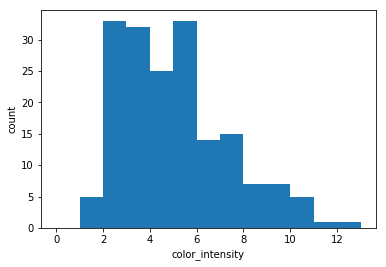

In [3]:
# Create the histogram
hist_feature_name='color_intensity'
bin_edges = np.arange(0, data[hist_feature_name].max() + 1, 1)
fig = plt.hist(data[hist_feature_name], bins=bin_edges)

plt.ylabel('count')
plt.xlabel(hist_feature_name)
plt.show()

At this point, we have the histogram for the color_intensity column. We can now discard the column and use the histogram. Naturally, this will not convey the full picture and some data is lost, but in order to reduce the dimensions, we can perform this Histogram Analysis.

In [4]:
data['alcohol'].head()

0    14.23
1    13.20
2    13.16
3    14.37
4    13.24
Name: alcohol, dtype: float64

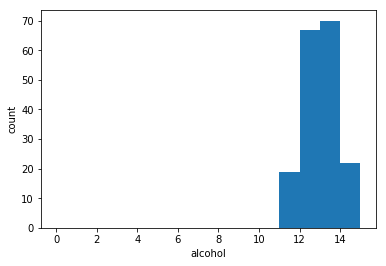

In [5]:
hist_feature_name='alcohol'
bin_edges = np.arange(0, data[hist_feature_name].max() + 1, 1)
fig = plt.hist(data[hist_feature_name], bins=bin_edges)

plt.ylabel('count')
plt.xlabel(hist_feature_name)
plt.show()

### Using Cosine Similarity

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
ash=data['ash']
ash=np.array(ash).reshape(1,-1)
ash

array([[2.43, 2.14, 2.67, 2.5 , 2.87, 2.45, 2.45, 2.61, 2.17, 2.27, 2.3 ,
        2.32, 2.41, 2.39, 2.38, 2.7 , 2.72, 2.62, 2.48, 2.56, 2.28, 2.65,
        2.36, 2.52, 2.61, 3.22, 2.62, 2.14, 2.8 , 2.21, 2.7 , 2.36, 2.36,
        2.7 , 2.65, 2.41, 2.84, 2.55, 2.1 , 2.51, 2.31, 2.12, 2.59, 2.29,
        2.1 , 2.44, 2.28, 2.12, 2.4 , 2.27, 2.04, 2.6 , 2.42, 2.68, 2.25,
        2.46, 2.3 , 2.68, 2.5 , 1.36, 2.28, 2.02, 1.92, 2.16, 2.53, 2.56,
        1.7 , 1.92, 2.36, 1.75, 2.21, 2.67, 2.24, 2.6 , 2.3 , 1.92, 1.71,
        2.23, 1.95, 2.4 , 2.  , 2.2 , 2.51, 2.32, 2.58, 2.24, 2.31, 2.62,
        2.46, 2.3 , 2.32, 2.42, 2.26, 2.22, 2.28, 2.2 , 2.74, 1.98, 2.1 ,
        2.21, 1.7 , 1.9 , 2.46, 1.88, 1.98, 2.27, 2.12, 2.28, 1.94, 2.7 ,
        1.82, 2.17, 2.92, 2.5 , 2.5 , 2.2 , 1.99, 2.19, 1.98, 2.  , 2.42,
        3.23, 2.73, 2.13, 2.39, 2.17, 2.29, 2.78, 2.3 , 2.38, 2.32, 2.4 ,
        2.4 , 2.36, 2.25, 2.2 , 2.54, 2.64, 2.19, 2.61, 2.7 , 2.35, 2.72,
        2.35, 2.2 , 2.15, 2.23, 2.48, 

In [7]:
phenols=np.array(data['total_phenols']).reshape(1,-1)
cosine_similarity(ash,phenols)

array([[0.96246358]])

We see that columns *ash* and *total_phenols* are 96% similar. So we can drop one of them and store the other one, there by reducing numerosity.

### Using Regression Analysis

In [8]:
from sklearn.linear_model import LinearRegression
magnesium=np.array(data['magnesium']).reshape(-1,1)
magnesium[0:5]
magnesium.shape

(178, 1)

In [9]:
y = np.array(data['category'])

In [10]:
model = LinearRegression()
model.fit(magnesium,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Now that we have a model of the *magnesium* column against the *category* class variable, we can safely drop *magnesium* without losing much info.

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv("video.csv")
data.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data.isnull().any() #look for nan values

Name                True
Platform           False
Year_of_Release     True
Genre               True
Publisher           True
NA_Sales           False
EU_Sales           False
JP_Sales           False
Other_Sales        False
Global_Sales       False
Critic_Score        True
Critic_Count        True
User_Score          True
User_Count          True
Developer           True
Rating              True
dtype: bool

In [4]:
data.isna().sum() # sum of nan values

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

In [5]:
data.dropna(axis=0,inplace=True) #dropping nan values
def div(n):
    return n/10
data.Critic_Score=data.Critic_Score.apply(div) # div 10 to Critic score to make similiar User score

data["Year_of_Release"]=data["Year_of_Release"].astype("int") # changing data types
data["User_Count"]=data["User_Count"].astype("int")
data["Critic_Count"]=data["Critic_Count"].astype("int")
data["User_Score"]=data["User_Score"].astype("float")

<a id="8"></a> 
**Heatmap**

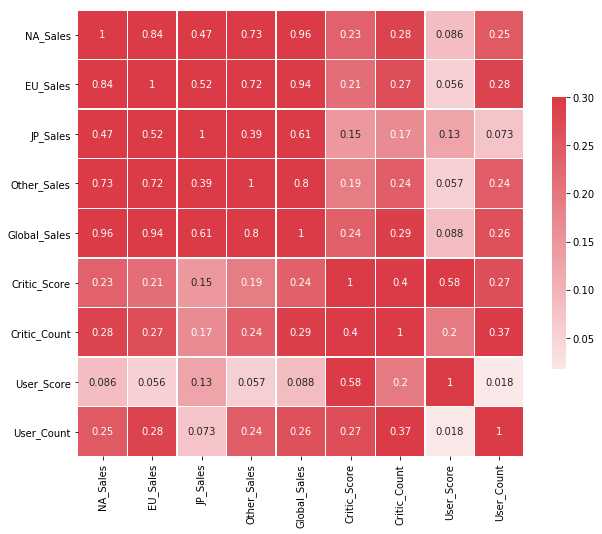

In [6]:
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(data.iloc[:,3:].corr(), cmap=cmap, vmax=.3, center=0,square=True,annot=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

<a id="10"></a> 
**Swarm Plot**

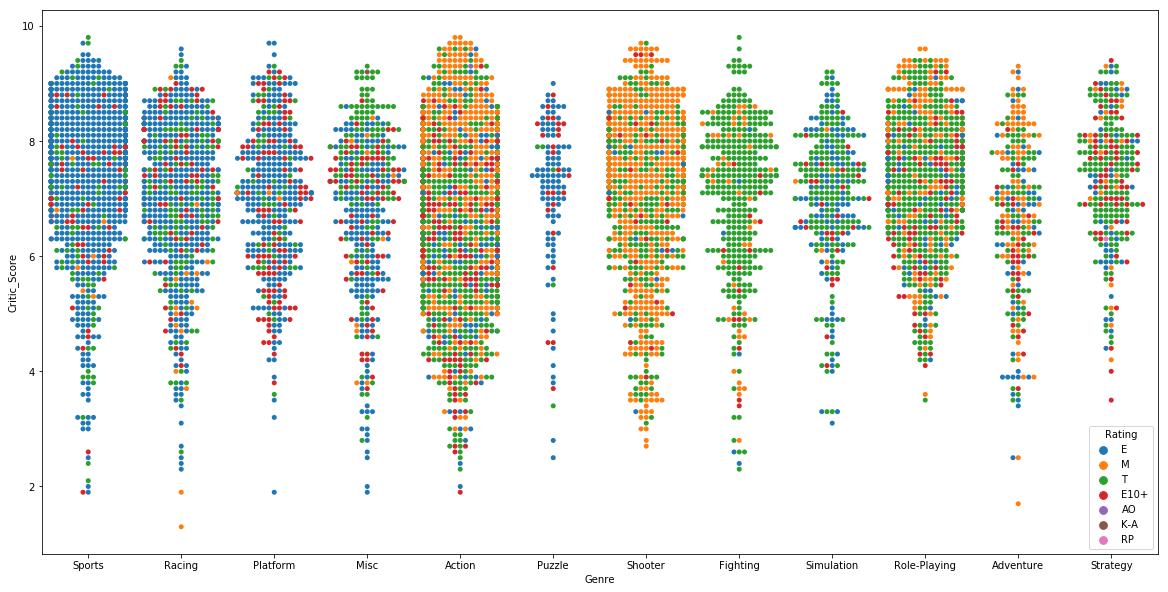

In [7]:
f,ax = plt.subplots(figsize=(20, 10))
sns.swarmplot(x=data.Genre, y=data.Critic_Score,hue=data.Rating)
plt.show()

<a id="11"></a> 
**Pair Plot**

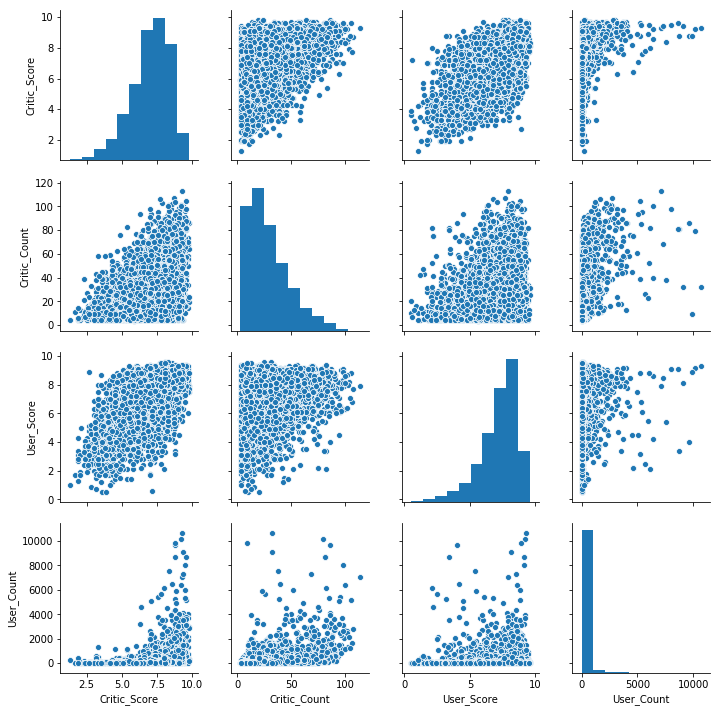

In [8]:
sns.pairplot(data.iloc[:,10:14])
plt.show()